# 번외: 시즌 간 차이 고려
- 시즌 간 차이 (한 시즌에서 다음 시즌이 나오기까지 걸린 일자) 를 고려한 결과 모델 성능은 더욱 향상되었습니다.
- 그러나 시즌 1만 존재하는 드라마의 경우, '시즌 간 차이' 요소를 고려할 수 없으므로 최종 모델로 선정하지는 않았습니다.
- 이 모델은 넷플릭스 드라마의 시즌 2가 나왔거나, 공개 예정일이 확장되었을 때에 한정하여 사용할 수 있습니다.

In [61]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import ast

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer

In [90]:
# 시각화 모듈 불러오기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 한국어 설정
from matplotlib import font_manager, rc
rc('font', family='Malgun Gothic')

# 마이너스 기호가 깨지지 않도록 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

## 01. 데이터 불러오기

In [62]:
# 데이터 불러오기 1
imdb = pd.read_excel('./imdb_final_6.xlsx', index_col=0)

# 딕셔너리 해제
for i in range(1, 12):
    imdb['season_{}'.format(i)] = imdb.loc[imdb['season_{}'.format(i)].notnull(), 'season_{}'.format(i)].apply(ast.literal_eval)

imdb.tail()

,korean_title,english_title,year,total_season_num,runtime,genre,age_rating,production_country,total_count,total_rate,...,season_9,season_10,season_11,director,writer,actor,imdb_title,imdb_url,wins,nominations
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
900,레일라,Leila,2019,1,46,"드라마, 전쟁, SF",15,인도,9300,5.1,...,NaN,NaN,NaN,"['Deepa Mehta', 'Pawan Kumar', 'Shanker Raman']","['Asad Hussain', 'Deepa Mehta', 'Patrick Graha...","['Huma Qureshi', 'Rahul Khanna', 'Siddharth', ...",Leila (TV Series 2019),https://www.imdb.com/title/tt9337588/,0,0
901,100만 엔의 여인들,Million Yen Women,2017,1,30,"스릴러, 범죄, 드라마, 로맨스",19,일본,2100,7.5,...,NaN,NaN,NaN,"['Hiroto Hara', 'Hirotoshi Hara', 'Kenji Kuwaj...","['Shunjû Aono', 'Yoshimiko Murooka', 'Yoshitak...","['Yôjirô Noda', 'Rila Fukushima', 'Rena Matsui...",1000000 yen no Onnatachi (TV Mini Series 2017),https://www.imdb.com/title/tt6686450/,0,0
902,킬러 코미디언,Hasmukh,2020,1,33,"범죄, 드라마, 스릴러, 코미디",19,인도,2800,5.4,...,NaN,NaN,NaN,['Nikhil Gonsalves'],"['Amogh Ranadive', 'Neeraj Pandey', 'Nikhil Go...","['Vir Das', 'Ranvir Shorey', 'Amrita Bagchi', ...",Hasmukh (TV Mini Series 2020),https://www.imdb.com/title/tt9359294/,2,1
903,달러,Dollar,2019,1,41,"액션, 드라마, 로맨스",15,레바논,651,6.6,...,NaN,NaN,NaN,['Samer Al Barkawi'],['Hisham Hilal'],"['Mark Lewis', 'Adel Karam', 'Amel Bouchoucha'...",Dollar (TV Series 2019),https://www.imdb.com/title/tt10687564/,0,0
904,"엘리트들, 못다 한 이야기: 나디아 구스만",Elite Short Stories: Nadia Guzmán,2021,1,11,"드라마, 로맨스",15,스페인,2100,6.2,...,NaN,NaN,NaN,['Dani de la Orden'],['Carlos Montero'],"['Miguel Bernardeau', 'Mina El Hammani', 'Omar...",Elite Short Stories: Nadia Guzmán (TV Mini Ser...,https://www.imdb.com/title/tt14671790/,0,0


In [63]:
# 데이터 불러오기 2
watcha = pd.read_excel('./watcha_최종본.xlsx', index_col=0)

# 리스트 해제
for i in range(1, 12):
    watcha['season_{}'.format(i)] = watcha.loc[watcha['season_{}'.format(i)].notnull(), 'season_{}'.format(i)].apply(ast.literal_eval)

watcha.tail()

,korean_title,english_title,year,total_season_num,production_country,watcha_name,season_1,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9,season_10,season_11
900,레일라,Leila,2019,1,인도,['레일라'],"[3.2, 27, 3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901,100만 엔의 여인들,Million Yen Women,2017,1,일본,['100만 엔의 여자들'],"[3.0, 718, 100]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
902,킬러 코미디언,Hasmukh,2020,1,인도,['킬러 코미디언'],"[1.6, 4, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,달러,Dollar,2019,1,레바논,['달러'],"[0.7, 3, 1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
904,"엘리트들, 못다 한 이야기: 나디아 구스만",Elite Short Stories: Nadia Guzmán,2021,1,스페인,"['엘리트들, 못다 한 이야기: 나디아 구스만']","[2.8, 420, 30]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 02. 함수 만들기

### (1) IMDb 평점, 평점 매긴 사람 수

In [64]:
# IMDb 평점
def get_imdb_rate(x):
    imdb_rate_lst = []

    # 딕셔너리에서 평점 부분만 가져옴
    for idx, val in x.items():
        imdb_rate_lst.append(val[0])

    # 시즌 평점 평균 구하기
    imdb_rate = np.mean(imdb_rate_lst)

    return imdb_rate

In [65]:
# IMDb 평점 매긴 사람 수
def get_imdb_rate_cnt(x):
    imdb_rate_cnt_lst = []

    # 딕셔너리에서 평점 매긴 사람만 가져옴
    for idx, val in x.items():
        imdb_rate_cnt_lst.append(val[1])


    # 평점을 매긴 사람의 시즌 평균 구하기
    imdb_rate_cnt = np.mean(imdb_rate_cnt_lst)

    return imdb_rate_cnt

### (2) 왓챠 평점, 평점을 매긴 사람 수

In [66]:
# 왓챠 평점
def get_watcha_rate(x):
    watcha_tmp = x
    watcha_rate = watcha_tmp[0]
    return watcha_rate

In [67]:
# 왓챠 평점을 매긴 사람 수
def get_watcha_rate_cnt(x):
    watcha_tmp = x
    watcha_rate_cnt = watcha_tmp[1]
    return watcha_rate_cnt

### (3) 유지도

In [69]:
# 평점 유지도
def get_rate_retention(x):
    imdb_tmp = list(x.values())
    k = len(imdb_tmp)
    score = (imdb_tmp[k-1][0] / imdb_tmp[0][0])
    return score

In [70]:
# 평점 매긴 사람 수의 유지도
def get_rate_cnt_retention(x):
    imdb_tmp = list(x.values())
    k = len(imdb_tmp)
    score = (imdb_tmp[k-1][1] / imdb_tmp[0][1])
    return score

### (4) 제작 국가

In [71]:
# 제작 국가 순위 별 점수 부여
country_scores = {
    "미국": 0.369,
    "대한민국": 0.203,
    "영국": 0.078,
    "스페인": 0.047,
    "멕시코": 0.030,
    "콜롬비아": 0.028,
    "캐나다": 0.024,
    "호주": 0.021,
    "중국": 0.020,
    "프랑스": 0.017,
    "일본": 0.016,
    "브라질": 0.016,
    "독일": 0.015,
    "인도": 0.014,
    "터키": 0.014,
    "이탈리아": 0.013,
    "폴란드": 0.011,
}
# "그 외" 비율
default_score = 0.005
def get_country_score(production_country):
    return country_scores.get(production_country, default_score)

### (5) 장르

In [72]:
# 넷플릭스 장르 선호도 순위 리스트 (선호도 순서대로 정렬)
genres = [
    '드라마', '코미디', 'SF', '액션', '스릴러', '범죄', '공포', '로맨스', '판타지', '전쟁', '서부', '그 외'
]

# 각 장르에 점수를 선형적으로 할당하여 딕셔너리로 만들기
genre_scores = {genre: 1 - i / (len(genres)) for i, genre in enumerate(genres)}

# '그 외'에 해당되는 장르 리스트
other_genres = ['역사', '가족', '음악', 'Made in Europe', '스포츠']

# 장르 문자열을 받아서 점수를 계산하는 함수

def get_genre_score(genre_str):
    # 장르를 ', '로 분리
    genre_list = genre_str.split(', ')
    
    # '그 외'에 포함된 하위 장르가 있는지 확인
    for genre in genre_list:
        if genre in other_genres:
            return genre_scores['그 외']
    
    # 각 장르의 점수의 평균 계산
    total_score = 0
    count = 0
    for genre in genre_list:
        score = genre_scores.get(genre, genre_scores['그 외'])  # 없는 장르는 '그 외' 점수로 처리
        total_score += score
        count += 1
    
    # 평균 점수 계산
    average_score = total_score / count if count > 0 else 0
    return average_score

### (6) 장르 다양성 지수

In [73]:
# 장르 다양성 지수
def get_genre_diversity(x):
    genre_len = len(x.split(', '))
    return genre_len

### (7) 연령 등급

In [74]:
# 연령 등급에 따른 함수
def get_age_rating_score(x):
    if x == 19:
        return 0.5
    elif x == 15:
        return 0.4
    else:
        return 0.1

### (8) 다음 시즌까지의 방영일자 (기준: 일(day))

In [75]:
# 시계열 데이터

from datetime import datetime

# 시즌별 데이터를 담을 리스트 만들기
season_columns = [f'season_{i}' for i in range(1, 3)]  # 시즌 1부터 시즌 2

# 결과를 담을 리스트 만들기
season_gaps = []

# 각 행을 순회하며 시즌 간격을 계산
for idx, row in imdb.iterrows():

    # 시즌 데이터를 담을 리스트 만들기
    seasons = []
    
    for season_col in season_columns:
        if season_col in row and pd.notnull(row[season_col]):
            season_data = row[season_col]
            seasons.append(season_data)
    
    # 시즌이 2개 이상인 경우에만 계산
    if len(seasons) > 1:
        for i in range(len(seasons) - 1):
            try:
                # 현재 시즌의 마지막 에피소드 방영일자
                last_episode_current_season = list(seasons[i].values())[-1][2]
                if last_episode_current_season:
                    last_air_date = datetime.strptime(last_episode_current_season, "%a, %b %d, %Y")
                else:
                    continue
                
                # 다음 시즌의 첫 번째 에피소드 방영일자
                first_episode_next_season = list(seasons[i + 1].values())[0][2]
                if first_episode_next_season:
                    next_air_date = datetime.strptime(first_episode_next_season, "%a, %b %d, %Y")
                else:
                    continue
                
                # 시즌 간의 간격 계산
                gap_days = (next_air_date - last_air_date).days

                imdb.at[idx, 'season_gaps'] = gap_days

            except KeyError as e:
                print(f"KeyError: {e} in row {idx} for season {i + 1} to season {i + 2}")
            except ValueError as e:
                print(f"ValueError: {e} in row {idx} for season {i + 1} to season {i + 2}")

In [76]:
# 방영일자 차이 계산
def get_season_gaps(x):
    gaps = 1 - (np.log(x) / max_gaps)
    return gaps

## 03. 점수 부여

In [77]:
# 시즌 2가 없는 드라마 모두 삭제
imdb = imdb[imdb['season_2'].notna()]
watcha = watcha[watcha['season_2'].notna()]

In [78]:
# 시즌2 점수 부여: 최종 모델
for idx, row in imdb.iterrows():
    imdb_tmp = imdb.loc[idx, 'season_2']; watcha_tmp = watcha.loc[idx, 'season_2']
    genre = imdb.loc[idx, 'genre']; country = imdb.loc[idx, 'production_country']; age = imdb.loc[idx, 'age_rating']

    rate = 0.8 * np.log(get_imdb_rate(imdb_tmp)) + 0.2 * np.log(get_watcha_rate(watcha_tmp))
    cnt = 0.8 * np.log(get_imdb_rate_cnt(imdb_tmp)) + 0.2 * np.log(get_watcha_rate_cnt(watcha_tmp))
    ret = 1/4 * np.log(get_rate_retention(imdb_tmp)) + 3/4 * np.log(get_rate_cnt_retention(imdb_tmp))
    info = 0.4 * get_country_score(country) + 0.4 * get_genre_score(genre) + 0.1 * np.log(get_genre_diversity(genre)) + 0.1 * (get_age_rating_score(age))
    total = (0.7 * (0.2 * rate + 0.6 * cnt + 0.2 * ret) + 0.3 * info) * 10

    imdb.loc[idx, 's2_score_final_log'] = total

## 04. 전처리

### (1) 각 컬럼에 함수 적용

In [79]:
imdb['production_country'] = imdb['production_country'].apply(get_country_score)
imdb['genre_diversity'] = imdb['genre'].apply(get_genre_diversity)
imdb['genre'] = imdb['genre'].apply(get_genre_score)
imdb['age_rating'] = imdb['age_rating'].apply(get_age_rating_score)

In [80]:
imdb['season_1_rate'] = imdb['season_1'].apply(get_imdb_rate)
imdb['season_1_rate_cnt'] = imdb['season_1'].apply(get_imdb_rate_cnt)
imdb['season_1_rate_retention'] = imdb['season_1'].apply(get_rate_retention)
imdb['season_1_rate_cnt_retention'] = imdb['season_1'].apply(get_rate_cnt_retention)

In [81]:
imdb['w_season_1_rate'] = watcha['season_1'].apply(get_watcha_rate)
imdb['w_season_1_rate_cnt'] = watcha['season_1'].apply(get_watcha_rate_cnt)

In [82]:
imdb['season_2_rate'] = imdb['season_2'].apply(get_imdb_rate)
imdb['season_2_rate_cnt'] = imdb['season_2'].apply(get_imdb_rate_cnt)
imdb['season_2_rate_retention'] = imdb['season_2'].apply(get_rate_retention)
imdb['season_2_rate_cnt_retention'] = imdb['season_2'].apply(get_rate_cnt_retention)

In [83]:
imdb['w_season_2_rate'] = watcha['season_2'].apply(get_watcha_rate)
imdb['w_season_2_rate_cnt'] = watcha['season_2'].apply(get_watcha_rate_cnt)

In [84]:
imdb['season_gaps'] = imdb['season_gaps'].apply(get_season_gaps)

### (2) 머신러닝을 위한 함수 만들기

In [85]:
# 모델 목록
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'LinearRegression': LinearRegression(),
    'AdaBoost': AdaBoostRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor()
}

# 하이퍼파라미터 그리드 (예시)
param_grids = {
    'DecisionTree': {'max_depth': [3, 5, 10, 20, None]},
    'LinearRegression': {},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10, 20, None]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'LightGBM': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

# 평가 지표를 위한 함수
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# 맞춤 평가 지표 추가
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSLE': make_scorer(mean_squared_log_error, greater_is_better=False),
    'RMSLE': make_scorer(rmsle, greater_is_better=False)
}

In [86]:
# 오징어 게임 시즌 2 예측
squid_game2_data = {
    'age_rating': [get_age_rating_score(15)],
    'genre': [get_genre_score('드라마, 스릴러')],
    'genre_diversity': [np.log(get_genre_diversity('드라마, 스릴러'))],
    'production_country': [get_country_score('한국')],
    'season_gaps': [get_season_gaps(926)],
    'season_1_rate': [np.log(8.1)],
    'season_1_rate_cnt': [np.log(500000)],
    'season_1_rate_retention': [np.log(0.8)],
    'season_1_rate_cnt_retention': [np.log(0.7)],
    'w_season_1_rate': [np.log(8.0)],
    'w_season_1_rate_cnt': [np.log(40000)]
}
squid_game2_df = pd.DataFrame(squid_game2_data)
squid_game2_df

,age_rating,genre,genre_diversity,production_country,season_gaps,season_1_rate,season_1_rate_cnt,season_1_rate_retention,season_1_rate_cnt_retention,w_season_1_rate,w_season_1_rate_cnt
0,0.4,0.833333,0.693147,0.005,0.210141,2.091864,13.122363,-0.223144,-0.356675,2.079442,10.596635


In [92]:
# 모델 평가 및 하이퍼파라미터 튜닝

def grid_search(X_train, X_test, y_train, y_test, y_name):

    best_models = {}; best_scores={}
    for name, model in models.items():
        print(f"Training {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        best_scores[name] = grid_search.best_score_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # 가장 성능이 좋은 모델 선택
    best_model_name = max(best_scores, key=best_scores.get)
    best_model = best_models[best_model_name]
    print(f"Best model: {best_model_name}")
    
    # 전체 데이터에 대한 예측
    y_pred_best = best_model.predict(X)

    # 예측 결과와 실제 결과를 비교
    comparison_df = pd.DataFrame({
        'korean_title': imdb['korean_title'],
        'actual': y_name,
        'predicted': y_pred_best,
        'diff': y_name - y_pred_best
    })
    
    # 오징어 게임에 대한 예측
    squid_game2_pred = best_model.predict(squid_game2_df)
    print(f"오징어게임2의 예상 흥행 점수: {squid_game2_pred[0]}")

    # 오징어게임2의 예측 점수를 다른 작품들과 비교
    average_actual = comparison_df['actual'].mean()
    average_predicted = comparison_df['predicted'].mean()
    print(f"평균 실제 흥행 점수: {average_actual}")
    print(f"평균 예측 흥행 점수: {average_predicted}")

    # 오징어게임2 점수 비교
    print(f"오징어게임2의 예상 흥행 점수: {squid_game2_pred[0]}")
    if squid_game2_pred[0] > average_predicted:
        print("오징어게임2의 예상 흥행 점수는 평균보다 높습니다.")
    else:
        print("오징어게임2의 예상 흥행 점수는 평균보다 낮습니다.")
    
    # 가장 성능이 좋은 모델의 피처 중요도 계산 및 시각화

    if best_model_name == 'LinearRegression':
        feature_importance_df = '없음'

        # 실제값과 예측값의 회귀선 시각화
        plt.figure(figsize=(7, 6))
        sns.regplot(x='actual', y='predicted', data=comparison_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
        plt.xlabel('실제 값')
        plt.ylabel('예측 값')
        plt.show()

    else:
        feature_importances = best_model.feature_importances_
        sorted_idx = np.argsort(feature_importances)
    
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
        plt.xlabel('Feature Importance')
        plt.title(f'{best_model_name} Feature Importances')
        plt.show()
    
        # 피처 중요도 데이터프레임 생성
        feature_importance_df = pd.DataFrame({
            'Feature': [X_train.columns[i] for i in sorted_idx],
            'Importance': feature_importances[sorted_idx]
        })

    # 각 모델에 대한 평가 지표 계산

    try:
        results_list = []
        for name, model in best_models.items():
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            msle = mean_squared_log_error(y_test, y_pred)
            rmsle_val = rmsle(y_test, y_pred)
            
            results_list.append({
                'Model': name,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'MSLE': msle,
                'RMSLE': rmsle_val
            })

    except:
        results_list = []
    
        for name, model in best_models.items():
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            
            results_list.append({
                'Model': name,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
            })
        
    finally:
        results = pd.DataFrame(results_list)
            
    return feature_importance_df, comparison_df, results

## 05. 머신러닝

C:\Users\mycom\AppData\Local\Temp\ipykernel_22556\853741428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['genre_diversity', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']] = X[['genre_diversity', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']].apply(lambda x: np.log(x))


Training DecisionTree...
Best parameters for DecisionTree: {'max_depth': 10}
Training LinearRegression...
Best parameters for LinearRegression: {}
Training AdaBoost...
Best parameters for AdaBoost: {'n_estimators': 50}
Training GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 100}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': 10, 'n_estimators': 100}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.2, 'n_estimators': 200}
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 42, number of used features: 8
[LightGBM] [Info] Start training from score 28.564296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

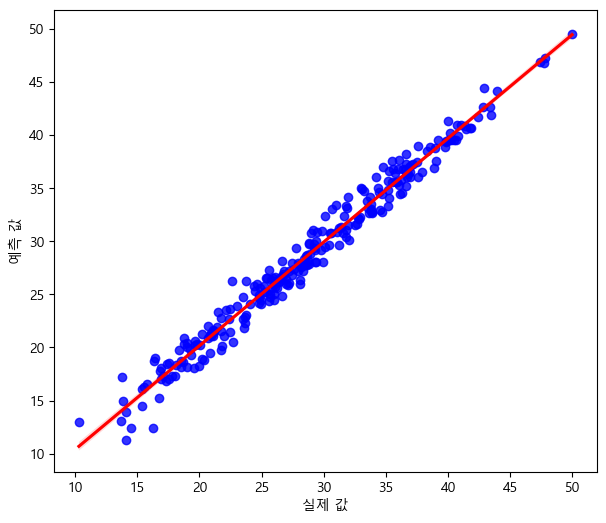

In [93]:
# 최종 모델에 더해 season gaps (다음 시즌까지의 일자) 고려
X = imdb[['age_rating', 'genre', 'genre_diversity', 'production_country', 'season_gaps', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']]
X[['genre_diversity', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']] = X[['genre_diversity', 'season_1_rate', 'season_1_rate_cnt', 'season_1_rate_retention', 'season_1_rate_cnt_retention', 'w_season_1_rate', 'w_season_1_rate_cnt']].apply(lambda x: np.log(x))
y = imdb['s2_score_final_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=13)

f_s_lo, c_s_lo, r_s_lo = grid_search(X_train, X_test, y_train, y_test, y)

In [57]:
# 모델 성능
r_s_lo

,Model,MSE,RMSE,MAE,MSLE,RMSLE
0,DecisionTree,8.901504,2.983539,2.354290,0.012554,0.112042
1,LinearRegression,1.350172,1.161969,0.918462,0.002444,0.049439
2,AdaBoost,7.708720,2.776458,2.157911,0.010791,0.103881
3,GradientBoosting,6.143805,2.478670,1.863093,0.008110,0.090056
4,RandomForest,6.269863,2.503969,1.920091,0.008294,0.091073
5,XGBoost,7.880821,2.807280,2.025466,0.009671,0.098342
6,LightGBM,11.910347,3.451137,2.660870,0.015550,0.124698


In [88]:
# 시즌 2 예측 상위 20개
c_s_lo.sort_values('predicted', ascending=False).head(20)

,korean_title,actual,predicted,diff
Unnamed: 0,,,,
46,블랙 미러,49.969542,49.539717,0.429825
17,브레이킹 배드,47.809068,47.243120,0.565948
7,워킹 데드,47.416472,46.888379,0.528093
24,기묘한 이야기,47.699495,46.794931,0.904563
31,위쳐,42.889669,44.436332,-1.546663
42,베터 콜 사울,43.954740,44.165719,-0.210980
27,피키 블라인더스,43.326873,42.641579,0.685294
54,덱스터,42.798994,42.633642,0.165352
13,다크,43.423898,41.906273,1.517625


In [89]:
# 시즌 2 예측 하위 20개
c_s_lo.sort_values('predicted', ascending=True).head(20)

,korean_title,actual,predicted,diff
Unnamed: 0,,,,
782,고르디우스의 매듭,14.123632,11.252800,2.870832
842,벨벳 컬렉션,16.291215,12.380730,3.910485
725,스타의 톤,14.504582,12.458645,2.045937
814,마사바와 마사바,10.307401,13.018717,-2.711316
143,하트브레이크 하이,13.701175,13.079705,0.621470
419,크리스마스를 망치는 방법,14.078347,13.914452,0.163896
386,캔 유 히어 미?,15.419106,14.485683,0.933423
402,다2어리,13.837151,14.912935,-1.075784
117,수업중입니다,16.766486,15.202094,1.564392
